In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import mpltern
import polyphase
plt.rcParams.update({"text.usetex": True})

import plotly.graph_objects as go
from plotly.figure_factory import create_trisurf

from scipy.spatial.distance import pdist, euclidean


In [4]:
systems={0:{'M':[789.266,11.36,1],'chi':[1.88,0.42,1.25]},
        1: {'M':[408.5,11.36,1],'chi':[1.33,0.34,1.25]}
        }
# M -- polymer, small molecule, solvent
# chi -- (p, sm);(p,solv);(solv, sm)
     
KEY = 0

3-dimensional grid generated at 0.23s
Energy computed at 3.00s
Making energy manifold a paraboloid with 2x padding of 0.44 maximum energy
Energy is corrected at 5.11s
Convexhull is computed at 5.13s
Simplices are refined at 5.15s
Total of 244 simplices in the convex hull
Using 5.03E-02 as a threshold for Laplacian of a simplex
Simplices are labelled at 5.29s
Labels are lifted at 5.83s
Total 0/244 coplanar simplices
Computation took 5.84s


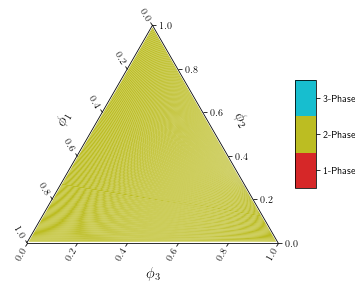

In [5]:
# default version
f = lambda x : polyphase.flory_huggins(x, systems[KEY]['M'], systems[KEY]['chi'])
engine = polyphase.PHASE(f,200, 3)

engine.compute(thresh_scale=10,verbose=True)
polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
plt.show()

Computation took 28.34s


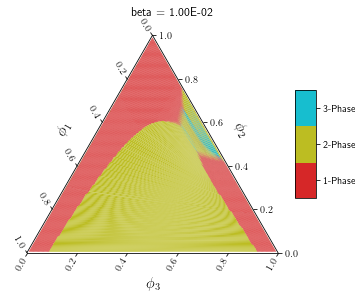

In [11]:
# Beta correction
betas = np.logspace(-2,-3,num=7)
for beta in betas:
    f = lambda x : polyphase.flory_huggins(x, systems[KEY]['M'], systems[KEY]['chi'], 
                                           beta=beta)
    engine = polyphase.PHASE(f,200, len(systems[KEY]['M']) )

    engine.compute(thresh_scale=10,verbose=False)
    polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
    fig = plt.gcf()
    fig.suptitle('beta = {:.2E}'.format(beta))
    plt.show()
    break

3-dimensional grid generated at 0.16s
Energy computed at 0.80s
Making energy manifold a paraboloid with 2x padding of 350.39 maximum energy
Energy is corrected at 2.91s
Convexhull is computed at 2.93s
Simplices are refined at 2.95s
Total of 244 simplices in the convex hull
Using 5.03E-02 as a threshold for Laplacian of a simplex
Simplices are labelled at 3.08s
Labels are lifted at 3.54s
Total 0/244 coplanar simplices
Computation took 3.55s


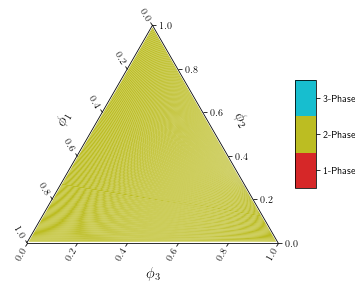

In [14]:
# scaled free enregy to check if there's computational issue
def f_scaled(x,M,chi):
    M_max = max(M)
    M_new = [M_max/M[0], M_max/M[1], M_max/M[2]]
    entropy = M_new[0]*x[0]*np.log(x[0]) + M_new[1]*x[1]*np.log(x[1]) + M_new[2]*x[2]*np.log(x[2])
    enthalpy = M_max*chi[0]*x[0]*x[1] + M_max*chi[1]*x[0]*x[2] + M_max*chi[2]*x[1]*x[2]
    
    return entropy + enthalpy  

f = lambda x : f_scaled(x, systems[KEY]['M'], systems[KEY]['chi'])
engine = polyphase.PHASE(f,200, 3)

engine.compute(thresh_scale=10,verbose=True)
polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
plt.show()

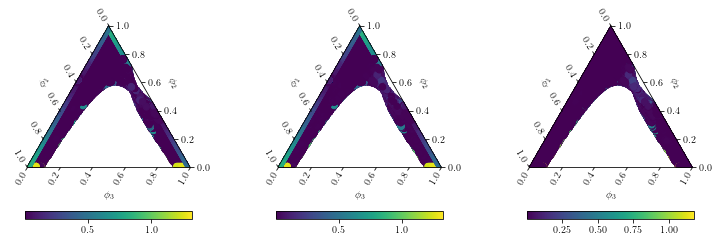

In [8]:
# plotting the pair-wise distances of each simplex
simplex_vertices = []
colors = []
for simplex in engine.simplices:
    coords = [engine.grid[:,x] for x in simplex]
    [simplex_vertices.append(x) for x in coords]
    dist = pdist(coords,'euclidean')
    [colors.append(dist) for _ in range(3)]

colors = np.asarray(colors)
simplex_vertices = np.asarray(simplex_vertices)

fig, axs = plt.subplots(nrows=1, ncols=3,
                        figsize=(4*3,4),
                        subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.5)
for i in range(3):
    cax = axs[i].scatter(simplex_vertices[:,2],simplex_vertices[:,0],simplex_vertices[:,1],
                  c = colors[:,i])
    fig.colorbar(cax, ax= axs[i], orientation="horizontal", pad=0.2)
    axs[i].set_tlabel(r'$\phi_2$')
    axs[i].set_llabel(r'$\phi_1$')
    axs[i].set_rlabel(r'$\phi_3$')
    axs[i].taxis.set_label_position('tick1')
    axs[i].laxis.set_label_position('tick1')
    axs[i].raxis.set_label_position('tick1')
    
plt.show()

/projects/academic/olgawodo/kiranvad/Projects/Spring2020/PhaseModelling/polyphase/utils.py:51: RuntimeWarning: invalid value encountered in log
  T1 += (xi*np.log(xi))/M[i] + beta/xi


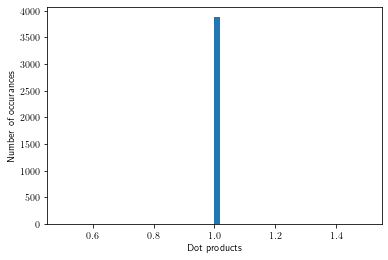

KeyboardInterrupt: 

In [22]:
# Tests
# 1. Tangent normal test
grad = polyphase.CentralDifference(engine.grid, f)
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==2)[0]
outlist = []
for simplex_id in phase_simplices_ids:
    try:
        test = polyphase.TestAngles(engine,phase=2,simplex_id=simplex_id)
    except RuntimeError:
        pass
    test_out = test.get_angles(grad)
    for _, value in test_out['thetas'].items():
        outlist.append([value[2], value[3]])

outlist = np.asarray(outlist)           
fig, ax = plt.subplots()
ax.hist(outlist[:,1],bins=50, density=False)
ax.set_ylabel('Number of occurances')
ax.set_xlabel('Dot products')
plt.show()

# Phase split test
PHASE_ID = 2
phase_simplices_ids = np.where(np.asarray(engine.num_comps)==PHASE_ID)[0]
failed = []
criteria = engine.df.T['label']==PHASE_ID
lengths = []
for simplex_id in phase_simplices_ids:
    try:
        test = polyphase.TestPhaseSplits(engine,phase=PHASE_ID,simplex_id=simplex_id, threshold=0.05)
        result = test.check_centroid()    
    except RuntimeError:
        result = False
    if not result:    
        failed.append(simplex_id)

print('{}/{} simplices failed the test'.format(len(failed), len(phase_simplices_ids))) 

In [15]:
# plot a interactive energy landscape
scene = dict(camera= dict(eye=dict(x=1.15, y=1.15, z=0.8)),
             aspectmode='cube', xaxis = dict(title='phi 1'), 
             yaxis = dict(title='phi 2'),
             zaxis = dict(title='energy'))

boundary_points= np.asarray([polyphase.is_boundary_point(x) for x in engine.grid.T])
trace1 = go.Scatter3d(x=engine.grid[0,~boundary_points], y=engine.grid[1,~boundary_points],
                      z=engine.energy[~boundary_points],mode='markers', 
                      marker=dict(size=5,opacity=0.2), name='Energy landscape')
fig_ch = create_trisurf(x=engine.grid[0,:], y=engine.grid[1,:], z=engine.energy, 
                      simplices=engine.simplices)
trace2 = fig_ch['data'][1]
fig = go.Figure(data=[trace1, trace2])
fig['layout']['scene'].update(scene)
a = ','.join('{:.2f}'.format(i) for i in systems[KEY]['M'])
b = ','.join('{:.2f}'.format(i) for i in systems[KEY]['chi'])
ab = 'M : {}\n chi: {}'.format(a,b)

fig['layout']['title'].update(dict(text=ab))
fig.write_html('../figures/notebooks/2.html')